# Bayesian cutoff analysis for Triton binding energy (LO/NLO/N2LO)

This notebook:
1. Parses TRITON output files grouped by chiral order (LO, NLO, N2LO) and cutoff values \(R\).
2. Estimates EFT uncertainty at each order from cutoff spread.
3. Computes discrete Bayesian posterior over \(R\) with a Gaussian likelihood.
4. Performs Bayesian Model Averaging (BMA) across cutoffs.
5. Produces plots and exports tables for the thesis.


In [1]:
import re
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Path to the folder that contains: cutoff_LO/, cutof_NLO/, cutoff_N2LO/
BASE_DIR = Path(r"results_cutoff")  

# Experimental value 
E_EXP = -8.482 #MeV

#Experimental uncertainty 
SIGMA_EXP = 0.01 #MeV

# Folder name mapping 
ORDER_MAP = {
    "cutoff_lo": "LO",
    "cutoff_nlo": "NLO",
    "cutoff_n2lo": "N2LO",
}

print("BASE_DIR:", BASE_DIR.resolve())

BASE_DIR: /mnt/c/Users/silvi/Desktop/TESI3/results_cutoff


In [3]:
def infer_order_from_path(p: Path) -> str:
    parts = [x.lower() for x in p.parts]
    for part in reversed(parts):
        if part in ORDER_MAP:
            return ORDER_MAP[part]
    raise ValueError(f"Cannot infer order from path: {p}")


def infer_R_from_filename(name: str) -> float:
    """
    Robust inference of R from filename.
    Supports:
      - R08 -> 0.8
      - R10 -> 1.0
      - R0.8 -> 0.8
      - any '0.8' substring
    """
    s = name.lower()

    # R08 / R10 / R12 pattern
    m = re.search(r"r(\d{2})", s)
    if m:
        two = int(m.group(1))
        return two / 10.0

    # R0.8 / R1.2 pattern
    m = re.search(r"r(\d+\.\d+)", s)
    if m:
        return float(m.group(1))

    # plain 0.8 pattern
    m = re.search(r"(\d+\.\d+)", s)
    if m:
        return float(m.group(1))

    raise ValueError(f"Cannot infer R from filename: {name}")


def read_triton_energy(file_path: Path) -> float:
    """
    Extract triton binding energy from a .dat file
    """
    text = file_path.read_text(errors="ignore")
    lines = text.splitlines()

    # float regex supports Fortran D exponents too
    float_re = r"[-+]?\d*\.\d+(?:[eEdD][-+]?\d+)?|[-+]?\d+(?:[eEdD][-+]?\d+)?"

    # targeted line search
    for line in lines[::-1]:
        low = line.lower()
        if ("triton" in low) or ("3h" in low) or ("binding" in low):
            nums = re.findall(float_re, line)
            if nums:
                return float(nums[-1].replace("D", "E").replace("d", "E"))

    # fallback: last number in file
    nums = re.findall(float_re, text)
    if not nums:
        raise ValueError(f"No numeric values found in {file_path}")
    return float(nums[-1].replace("D", "E").replace("d", "E"))

In [10]:
rows = []
for fp in BASE_DIR.rglob("*.dat"):
    order = infer_order_from_path(fp)
    R = infer_R_from_filename(fp.name)
    E = read_triton_energy(fp)
    rows.append({"order": order, "R": R, "E_triton (MeV)": E, "file": str(fp)})

df = pd.DataFrame(rows)
if df.empty:
    raise RuntimeError(f"No .dat files found under {BASE_DIR.resolve()}")

df = df.sort_values(["order", "R"]).reset_index(drop=True)

df[["order", "R", "E_triton (MeV)"]]

,order,R,E_triton (MeV)
0,LO,0.8,-12.032300
1,LO,0.9,-11.746060
2,LO,1.0,-11.296000
3,LO,1.1,-10.822980
4,LO,1.2,-10.395280
5,N2LO,0.8,-8.007803
6,N2LO,0.9,-8.142990
7,N2LO,1.0,-8.283478
8,N2LO,1.1,-8.429675
9,N2LO,1.2,-8.580848


In [11]:
counts = df.groupby("order")["R"].count()
display(counts)

display(df.groupby("order")["R"].unique())

order
LO      5
N2LO    5
NLO     5
Name: R, dtype: int64

order
LO      [0.8, 0.9, 1.0, 1.1, 1.2]
N2LO    [0.8, 0.9, 1.0, 1.1, 1.2]
NLO     [0.8, 0.9, 1.0, 1.1, 1.2]
Name: R, dtype: object

In [13]:
eft = (
    df.groupby("order")["E_triton (MeV)"]
      .std(ddof=1)
      .reset_index()
      .rename(columns={"E_triton (MeV)": "sigma_eft"})
)

df = df.merge(eft, on="order", how="left")
df["sigma_tot"] = np.sqrt(SIGMA_EXP**2 + df["sigma_eft"]**2)

eft

,order,sigma_eft
0,LO,0.665717
1,N2LO,0.226598
2,NLO,0.272005


In [15]:
df["logL"] = -0.5 * (df["E_triton (MeV)"] - E_EXP)**2 / (df["sigma_tot"]**2)
df["posterior_R"] = 0.0

for order in df["order"].unique():
    m = df["order"] == order
    logL = df.loc[m, "logL"].to_numpy()

    # uniform prior over available cutoffs
    w = np.exp(logL - logL.max())
    df.loc[m, "posterior_R"] = w / w.sum()

df[["order", "R", "E_triton (MeV)", "sigma_eft", "posterior_R"]]

,order,R,E_triton (MeV),sigma_eft,posterior_R
0,LO,0.8,-12.032300,0.665717,0.000037
1,LO,0.9,-11.746060,0.665717,0.000330
2,LO,1.0,-11.296000,0.665717,0.007218
3,LO,1.1,-10.822980,0.665717,0.112950
4,LO,1.2,-10.395280,0.665717,0.879467
5,N2LO,0.8,-8.007803,0.226598,0.037419
6,N2LO,0.9,-8.142990,0.226598,0.108922
7,N2LO,1.0,-8.283478,0.226598,0.226913
8,N2LO,1.1,-8.429675,0.226598,0.324079
9,N2LO,1.2,-8.580848,0.226598,0.302667


In [16]:
bma_rows = []
for order in df["order"].unique():
    sub = df[df["order"] == order]
    w = sub["posterior_R"].to_numpy()
    E = sub["E_triton (MeV)"].to_numpy()

    mean = float(np.sum(w * E))
    var = float(np.sum(w * (E - mean)**2))
    sd = float(np.sqrt(var))

    bma_rows.append({"order": order, "E_mean": mean, "E_sd": sd})

bma = pd.DataFrame(bma_rows)

# Force order ordering LO, NLO, N2LO
order_cat = pd.Categorical(bma["order"], categories=["LO", "NLO", "N2LO"], ordered=True)
bma = bma.assign(order=order_cat).sort_values("order").reset_index(drop=True)

bma

,order,E_mean,E_sd
0,LO,-10.450595,0.155426
1,NLO,-8.441016,0.205217
2,N2LO,-8.395244,0.161843


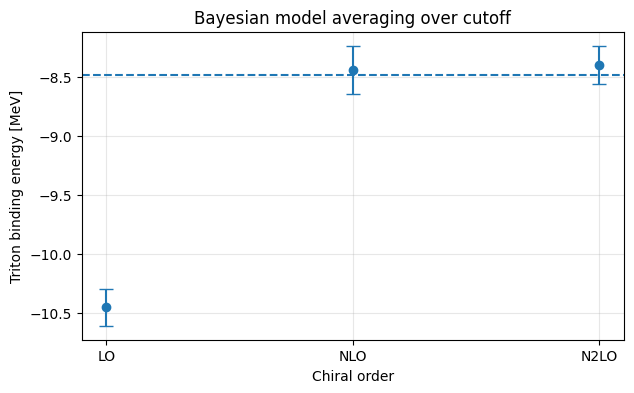

In [17]:
plt.figure(figsize=(7,4))
plt.errorbar(bma["order"], bma["E_mean"], yerr=bma["E_sd"], fmt="o", capsize=5)
plt.axhline(E_EXP, linestyle="--")
plt.ylabel("Triton binding energy [MeV]")
plt.xlabel("Chiral order")
plt.title("Bayesian model averaging over cutoff")
plt.grid(True, alpha=0.3)
plt.show()

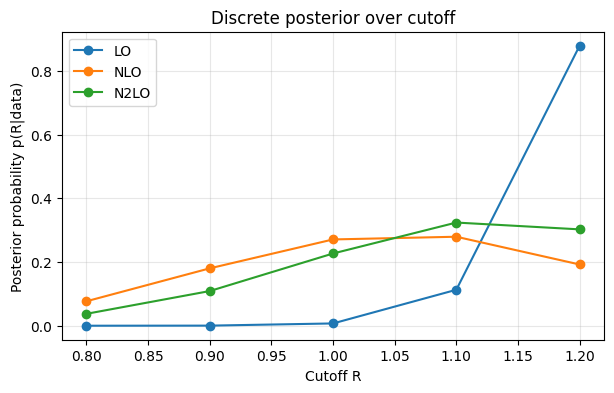

In [20]:
plt.figure(figsize=(7,4))

for order in ["LO", "NLO", "N2LO"]:
    sub = df[df["order"] == order].sort_values("R")
    plt.plot(sub["R"], sub["posterior_R"], marker="o", label=order)

plt.xlabel("Cutoff R")
plt.ylabel("Posterior probability p(R|data)")
plt.title("Discrete posterior over cutoff")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [19]:
out_dir = Path("analysis_outputs")
out_dir.mkdir(exist_ok=True)

df.to_csv(out_dir / "parsed_triton_results.csv", index=False)
bma.to_csv(out_dir / "bma_results.csv", index=False)
eft.to_csv(out_dir / "eft_sigma_from_cutoff_spread.csv", index=False)

# Save figures
plt.figure(figsize=(7,4))
plt.errorbar(bma["order"], bma["E_mean"], yerr=bma["E_sd"], fmt="o", capsize=5)
plt.axhline(E_EXP, linestyle="--")
plt.ylabel("Triton binding energy [MeV]")
plt.xlabel("Chiral order")
plt.title("Bayesian model averaging over cutoff")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(out_dir / "bma_over_orders.png", dpi=200)
plt.close()

plt.figure(figsize=(7,4))
for order in ["LO", "NLO", "N2LO"]:
    sub = df[df["order"] == order].sort_values("R")
    plt.plot(sub["R"], sub["posterior_R"], marker="o", label=order)
plt.xlabel("Cutoff R")
plt.ylabel("Posterior probability p(R | data)")
plt.title("Discrete posterior over cutoff")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(out_dir / "posterior_over_R.png", dpi=200)
plt.close()

print("Saved outputs in:", out_dir.resolve())

Saved outputs in: /mnt/c/Users/silvi/Desktop/TESI3/analysis_outputs


## Discussion and interpretation

The discrete Bayesian analysis over the regulator cutoff \(R\) provides a clear and physically consistent picture of the behavior of the chiral interaction at different orders.

At **leading order (LO)**, the posterior distribution is strongly peaked at the largest cutoff value. This reflects the well-known limitations of the LO interaction, which tends to overbind the triton and exhibits a strong sensitivity to short-range regularization. In this regime, the cutoff effectively compensates for missing higher-order contributions, resulting in a pronounced regulator dependence.

At **next-to-leading order (NLO)**, the posterior over \(R\) becomes significantly broader. The probability mass is distributed over a wide range of cutoff values, indicating a substantial reduction of regulator sensitivity. This behavior signals an improved description of short-range physics due to the inclusion of subleading contact interactions.

At **next-to-next-to-leading order (N2LO)**, the posterior is nearly flat across the considered cutoff range. This is a desirable feature: it indicates that the predicted triton binding energy is largely insensitive to the choice of regulator within the estimated theoretical uncertainty. Such behavior is consistent with the expected convergence pattern of chiral effective field theory and supports the interpretation of residual cutoff dependence as a higher-order effect.

Overall, this analysis demonstrates that:
- the regulator dependence decreases systematically with chiral order,
- the EFT truncation uncertainty inferred from cutoff variation is reduced at higher orders,
- Bayesian model averaging provides a principled way to combine predictions from different regulator choices without arbitrary selections.

Having established regulator stability at NLO and N2LO, this framework provides a solid foundation for the next stage of the analysis, in which continuous low-energy parameters will be introduced and calibrated within the same Bayesian setting.


## Sensitivity analysis of LO contact low-energy constants

After establishing that the regulator dependence is under control and selecting a reference cutoff value \(R = 1.0 fm\), we now turn to the role of the low-energy constants (LECs) entering the leading-order (LO) contact interaction.

In chiral effective field theory, LO contact LECs encode unresolved short-range physics and are expected to play a central role in few-body observables. However, not all contact couplings contribute equally to a given observable. Since the present analysis is based on a single three-body measurement (the triton binding energy), it is neither possible nor meaningful to vary all LO LECs simultaneously in a Bayesian calibration.

Instead, we first perform a finite-difference sensitivity analysis to identify which LO contact LECs have a significant impact on the triton binding energy at fixed order and cutoff. Each LO contact coupling is perturbed individually by a small relative amount (1%), while all others are kept at their nominal values. The resulting change in the triton binding energy provides a quantitative measure of the sensitivity of the observable to that specific LEC.

Following standard practices in uncertainty quantification for chiral effective field theory
(see e.g. Furnstahl et al., Phys. Rev. C 92, 024005),
we study the local sensitivity of the triton binding energy to the LO contact low-energy constants.

The binding energy is treated as a function of the EFT parameters $E = E(C_1, C_2, \ldots),$ and its parametric dependence is probed by rescaling one LEC at a time as:

$C_i \rightarrow (1+\delta)\,C_i,
\qquad \delta = 0.01.$

Assuming a locally linear response, the sensitivity is estimated through a finite-difference approximation,
$
\frac{\partial E}{\partial C_i}
\approx
\frac{E_i - E_0}{\delta},
$
where $E_0$ is the reference energy and $E_i$ the energy obtained after the variation of $C_i$.

To compare the relative impact of different contact terms, we also define a dimensionless sensitivity measure
$
S_i^{\mathrm{rel}} = \frac{|E_i - E_0|}{|E_0|}.
$


This procedure allows us to:
- objectively rank the LO contact LECs according to their influence on the triton binding energy,
- discard parameters that are effectively unconstrained by the observable,
- and select a minimal, well-identified set of LECs for subsequent Bayesian inference.

In the following, we present the results of this sensitivity analysis and use them to motivate the choice of LO contact LECs that will be varied in the Bayesian calibration.


E0 (baseline) = -11.29600 MeV


,LEC_index,E_i [MeV],E_i - E0 [MeV],S_i = dE/dlnC [MeV],|S_i|,importance,cum_importance
0,2,-11.57935,-0.28335,-28.335,28.335,0.597079,0.597079
1,3,-11.42245,-0.12645,-12.645,12.645,0.266457,0.863537
2,1,-11.36076,-0.06476,-6.476,6.476,0.136463,1.000000
3,4,-11.29600,0.00000,0.000,0.000,0.000000,1.000000


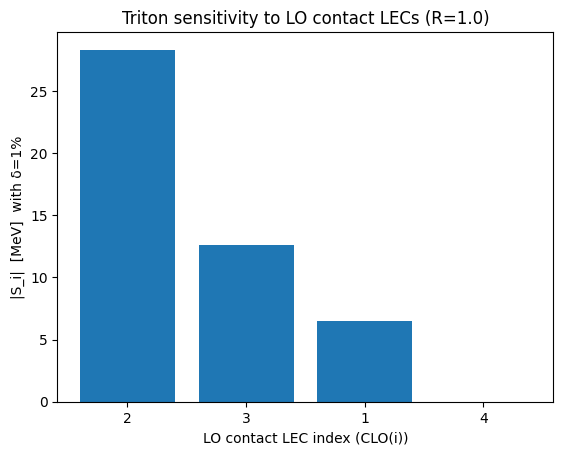

In [ ]:
import re
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

BASE_DIR = Path("results_LEC_sens_LO")

files = {
    0: BASE_DIR / "output_0.dat",  # baseline (no override)
    1: BASE_DIR / "output_1.dat",  # "1 1.01"
    2: BASE_DIR / "output_2.dat",  # "2 1.01"
    3: BASE_DIR / "output_3.dat",  # "3 1.01"
    4: BASE_DIR / "output_4.dat",  # "4 1.01"
}

def extract_triton_energy(path: Path) -> float:
    txt = path.read_text(errors="ignore")
    m = re.search(r"Triton binding energy\s*=\s*([-\d\.E\+]+)", txt)
    if not m:
        raise ValueError(f"Could not find triton energy in {path}")
    return float(m.group(1))  #MeV

E = {k: extract_triton_energy(v) for k, v in files.items()}
E0 = E[0]
delta = 0.01

rows = []
for i in [1, 2, 3, 4]:
    Si = (E[i] - E0) / delta
    rows.append({
        "LEC_index": i,
        "E_i [MeV]": E[i],
        "E_i - E0 [MeV]": E[i] - E0,
        "S_i = dE/dlnC [MeV]": Si,
        "|S_i|": abs(Si),
    })

df = pd.DataFrame(rows).sort_values("|S_i|", ascending=False).reset_index(drop=True)
df["importance"] = df["|S_i|"] / df["|S_i|"].sum()
df["cum_importance"] = df["importance"].cumsum()

print(f"E0 (baseline) = {E0:.5f} MeV")
display(df)

# Simple plot (no custom colors)
plt.figure()
plt.bar(df["LEC_index"].astype(str), df["|S_i|"])
plt.xlabel("LO contact LEC index (CLO(i))")
plt.ylabel("|S_i|  [MeV]  with δ=1%")
plt.title("Triton sensitivity to LO contact LECs (R=1.0)")
plt.show()

In [3]:
threshold = 0.90
picked = df.loc[df["cum_importance"] <= threshold, "LEC_index"].tolist()
# include the one that crosses the threshold
if df["cum_importance"].iloc[len(picked)] > threshold:
    picked.append(int(df["LEC_index"].iloc[len(picked)]))

print("Picked LECs (>=90% cumulative importance):", picked)

Picked LECs (>=90% cumulative importance): [2, 3, 1]


### Interpretation

The sensitivity analysis reveals a clear hierarchy among the LO contact LECs. 2 couplings dominate the response of the triton binding energy, while 1 coupling has a subleading effect and another is effectively irrelevant within numerical accuracy.

In particular, the 4th LO contact coupling shows no measurable impact on the triton binding energy for a 1% variation, indicating that this parameter is not identifiable from the present observable at LO and fixed cutoff. It is therefore kept fixed in the remainder of the analysis.

Based on the cumulative sensitivity, we select a minimal subset of LO contact LECs that accounts for the dominant contribution to the triton binding energy. This choice ensures a statistically well-posed Bayesian calibration and avoids introducing unconstrained parameters whose posterior distributions would be dominated by the prior.

The selected LO contact LECs will be treated as free parameters in the next stage of the analysis, while the remaining LO couplings are fixed at their nominal values.
